- Check for Colab Env
> if we are in colab env we need to get the data + scripts from github or somewhere

In [1]:
import os
if "COLAB_GPU" in os.environ:
    _useMultiProcessing = False
    os.system("git clone https://github.com/zaxo7/UNet-Playground.git")
    os.chdir("/content/UNet-Playground/")
else:
    _useMultiProcessing = True
    
if "PAPERSPACE_FQDN" in os.environ:
    !apt update
    !apt install libgl1 -y
    !pip install opencv-python
    !git pull


Hit:1 http://archive.ubuntu.com/ubuntu focal InRelease
Get:2 http://archive.ubuntu.com/ubuntu focal-updates InRelease [114 kB]
Get:3 http://archive.ubuntu.com/ubuntu focal-backports InRelease [108 kB]      
Get:4 http://security.ubuntu.com/ubuntu focal-security InRelease [114 kB]      
Get:5 http://archive.ubuntu.com/ubuntu focal-updates/universe amd64 Packages [1161 kB]
Get:6 http://archive.ubuntu.com/ubuntu focal-updates/main amd64 Packages [2256 kB]
Get:7 http://archive.ubuntu.com/ubuntu focal-updates/restricted amd64 Packages [1266 kB]
Get:8 http://archive.ubuntu.com/ubuntu focal-updates/multiverse amd64 Packages [30.2 kB]
Get:9 http://archive.ubuntu.com/ubuntu focal-backports/main amd64 Packages [53.8 kB]
Get:10 http://archive.ubuntu.com/ubuntu focal-backports/universe amd64 Packages [27.1 kB]
Get:11 http://security.ubuntu.com/ubuntu focal-security/main amd64 Packages [1816 kB]
Get:12 http://security.ubuntu.com/ubuntu focal-security/restricted amd64 Packages [1174 kB]
Get:13 http:

- enable module autoreload and fix an import bug

In [ ]:
%load_ext autoreload
%autoreload 2


import sys,os
sys.path.append(os.getcwd() + '/scripts')

: 

- import the scripts and data

In [ ]:
from scripts import data, model
import glob
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from DataGenerator import DataGenerator

: 

- load the dataset
- and ceate image slices

- slice each image to small samples of size 188*188
- imgs -> rgb image
- mask -> mask
- edge -> edge_mask

In [ ]:
database = "data2"

_batch_size = 8

train_img_tile_files = sorted(glob.glob(f'{database}/train/tiles/*.jpg'))
train_mask_tile_label_files = sorted(glob.glob(f'{database}/train/WBC_mask/tiles/*.jpg'))

test_img_tile_files = sorted(glob.glob(f'{database}/test/tiles/*.jpg'))
test_mask_tile_label_files = sorted(glob.glob(f'{database}/test/WBC_mask/tiles/*.jpg'))


train_gen = DataGenerator(train_img_tile_files, train_mask_tile_label_files, None, _batch_size, skip_empty = True)

test_gen = DataGenerator(test_img_tile_files, test_mask_tile_label_files, None, _batch_size, skip_empty = True, augment=False)

#train = model.generate_train_dataset(train_img_files)

#train_generator = model.generate_train_dataset(train_img_files)

#train_set = model.generate_train_dataset_tf(train_img_files)



#test_img_chips, test_mask_chips, test_edge_chips = model.generate_test_dataset(test_img_files)

#train_img_chips, train_mask_chips, train_edge_chips = model.generate_test_dataset(train_img_files)



#test_set = model.generate_test_dataset_tf(test_img_files)


: 

/home/zaxo7/WorkSpace/DEEP LEARNING/MY-U-NET/scripts/data.py:420: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[coords] = 1
/home/zaxo7/WorkSpace/DEEP LEARNING/MY-U-NET/scripts/data.py:426: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[coords] = 0
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0.

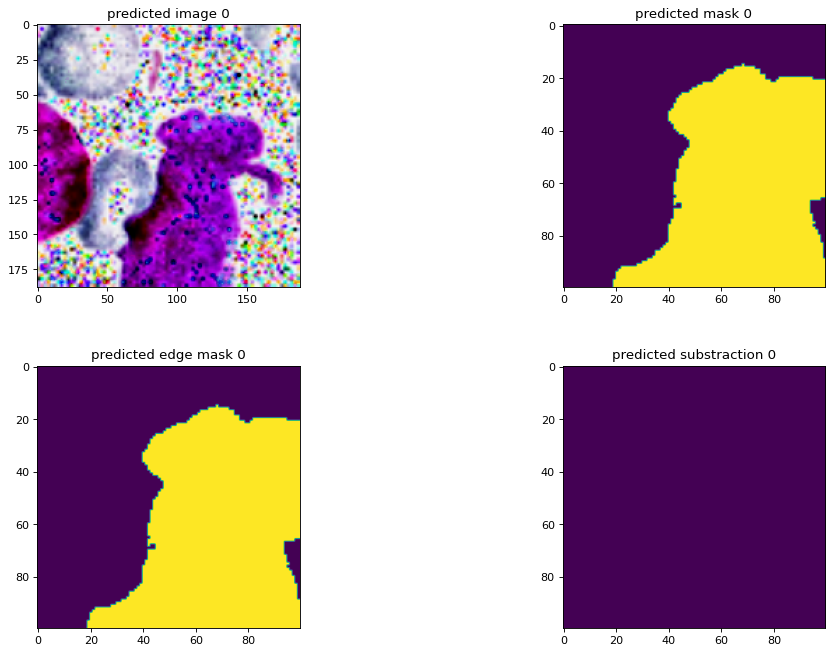

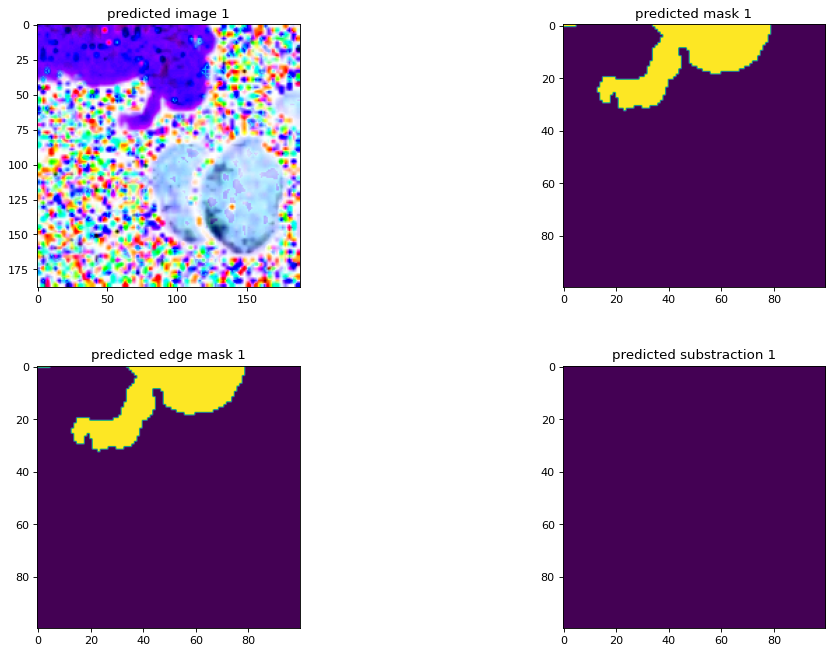

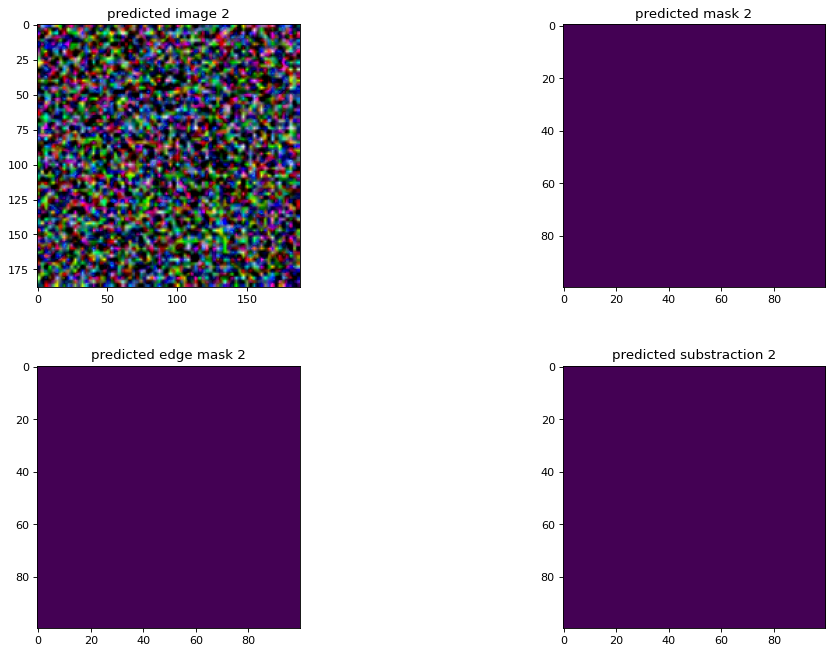

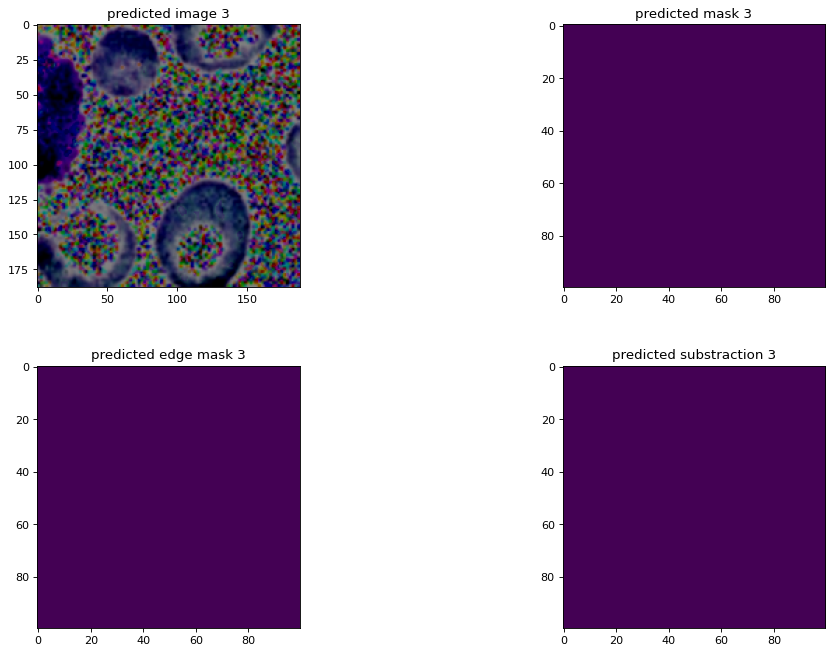

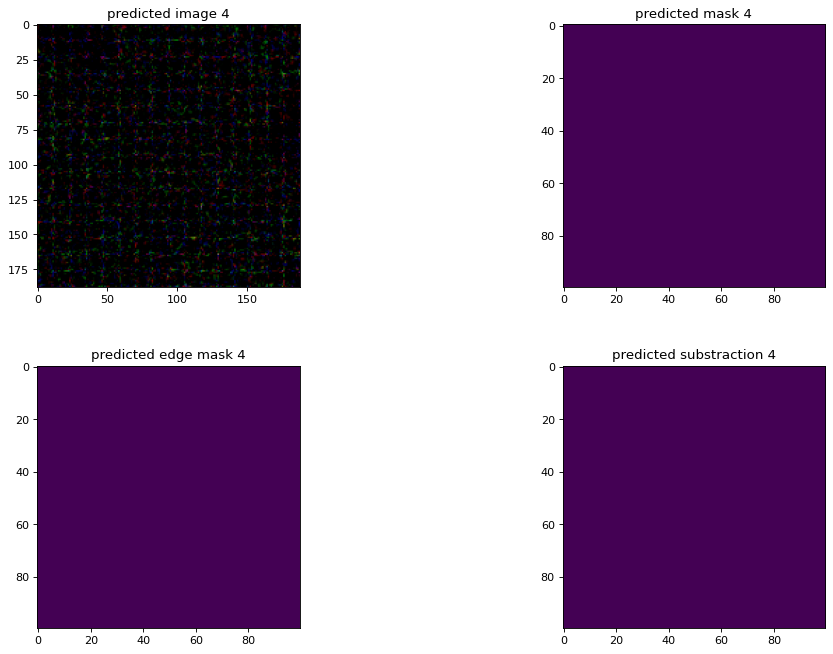

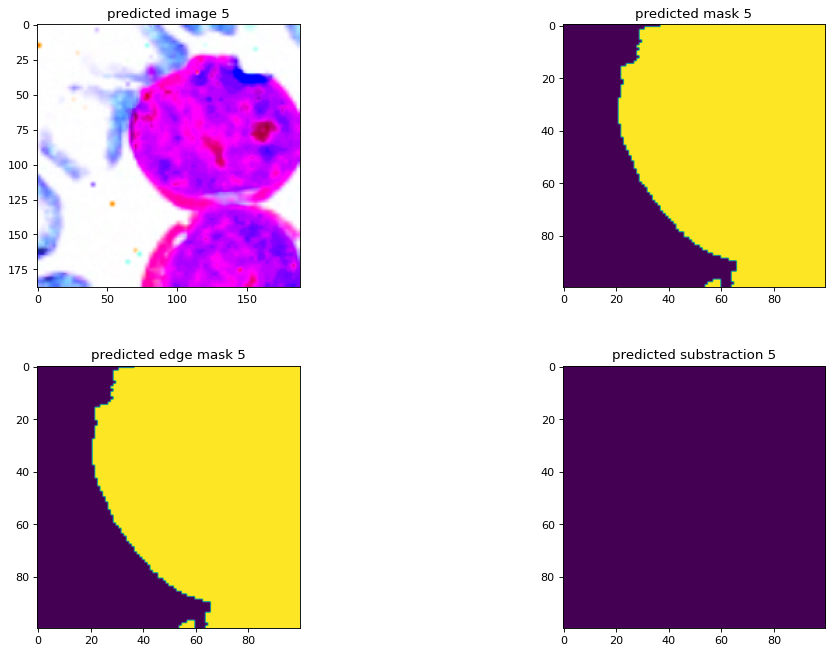

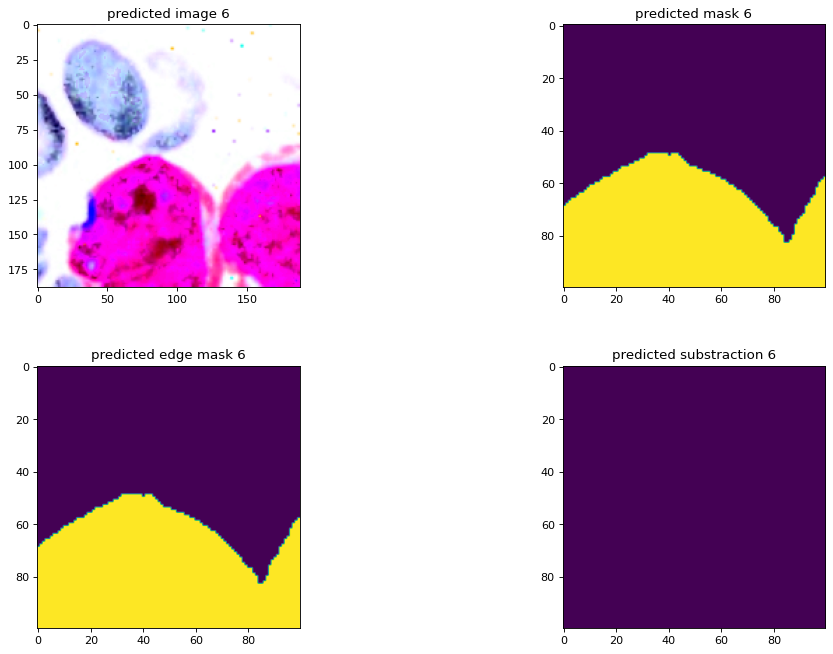

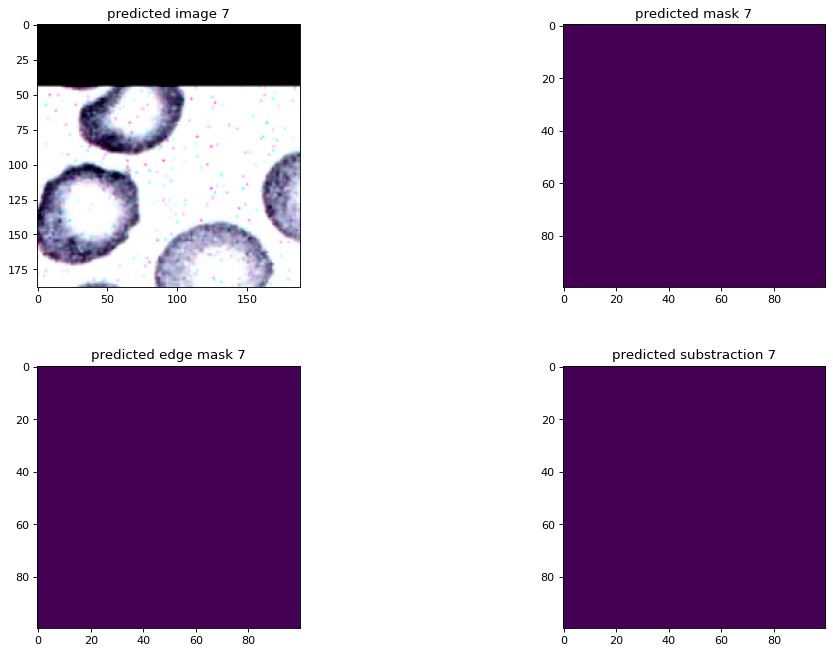

In [20]:
image, mask = train_gen.__getitem__(16)

data.plot_ime(image, mask, mask)

- create the model and compile it

In [21]:
unet = model.get_do_unet_WBC()

#unet.compile(optimizer="adam",
#             loss=model.tversky_loss,
#             metrics=[model.mean_iou, model.dsc, model.tversky, model.tversky_b, 'acc'])
                      

#unet.summary()

2022-05-23 15:31:50.715458: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/zaxo7/tensorflow/lib/python3.8/site-packages/cv2/../../lib64:
2022-05-23 15:31:50.740107: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-05-23 15:31:50.769342: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (zx-d): /proc/driver/nvidia/version does not exist
2022-05-23 15:31:50.890789: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


- model parameters

In [22]:
_batch_size = 8
_epochs = 50
_workers = 8
_model_name = f'WBC_binaryCrossEntrophy_{_epochs}'
images_per_epoch = 33900
train_steps = images_per_epoch//_batch_size
#validation_steps = len(test_img_files)//_batch_size

Train = True

- load weights

In [ ]:
unet.load_weights(f"models/{_model_name}_best.h5")

- Train the model

In [26]:
if Train:
    history = unet.fit(train_gen, 
            epochs=_epochs, 
            validation_data=test_gen, 
            steps_per_epoch=train_steps,
            max_queue_size=2*_workers,
            use_multiprocessing=True,
            workers=_workers,
            verbose=1,
            callbacks=model.get_callbacks(_model_name))
    # saving the model in tensorflow format
    #model.save(f'./models/{_model_name}',save_format='tf')

loading batch number 0 which has shape image : (8, 188, 188, 3) mask : (8, 100, 100, 1)
Epoch 1/50
loading batch number 2657 which has shape image : (8, 188, 188, 3) mask : (8, 100, 100, 1)loading batch number 1667 which has shape image : (8, 188, 188, 3) mask : (8, 100, 100, 1)loading batch number 4216 which has shape image : (8, 188, 188, 3) mask : (8, 100, 100, 1)loading batch number 3938 which has shape image : (8, 188, 188, 3) mask : (8, 100, 100, 1)loading batch number 3406 which has shape image : (8, 188, 188, 3) mask : (8, 100, 100, 1)loading batch number 3131 which has shape image : (8, 188, 188, 3) mask : (8, 100, 100, 1)loading batch number 367 which has shape image : (8, 188, 188, 3) mask : (8, 100, 100, 1)loading batch number 3315 which has shape image : (8, 188, 188, 3) mask : (8, 100, 100, 1)







loading batch number 3209 which has shape image : (8, 188, 188, 3) mask : (8, 100, 100, 1)
loading batch number 3402 which has shape image : (8, 188, 188, 3) mask : (8, 100, 

KeyboardInterrupt: 

- save the training log 

In [8]:
#save the training log into a file
import json
my_dict = {'a':11,'b':22,'c':33}
with open(f"models/{_model_name}_log.json", "a+") as fp:
    json.dump(history.history,fp)

# Opening JSON file
with open(f"models/{_model_name}_log.json") as fp:
    # returns JSON object as
    # a dictionary
    loaded_hist = json.load(fp)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

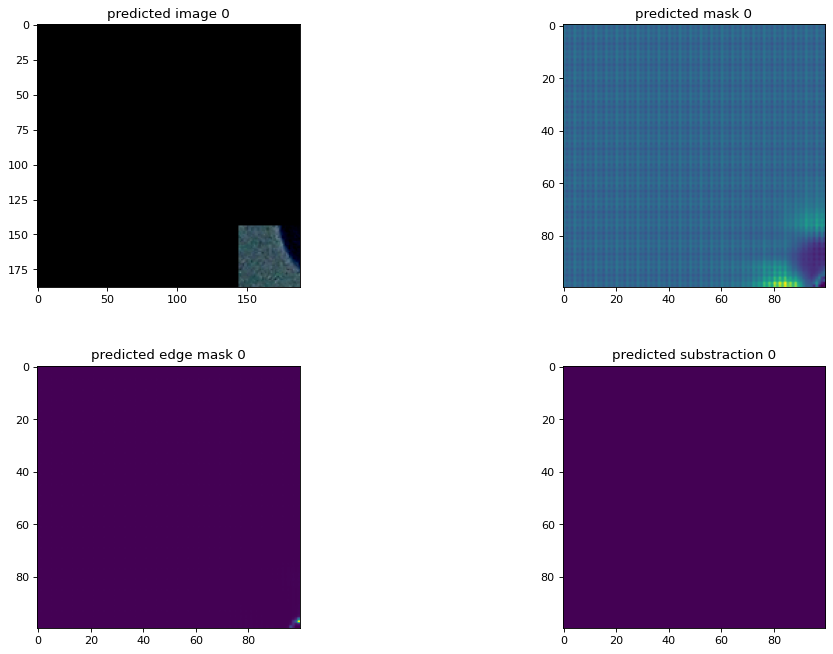

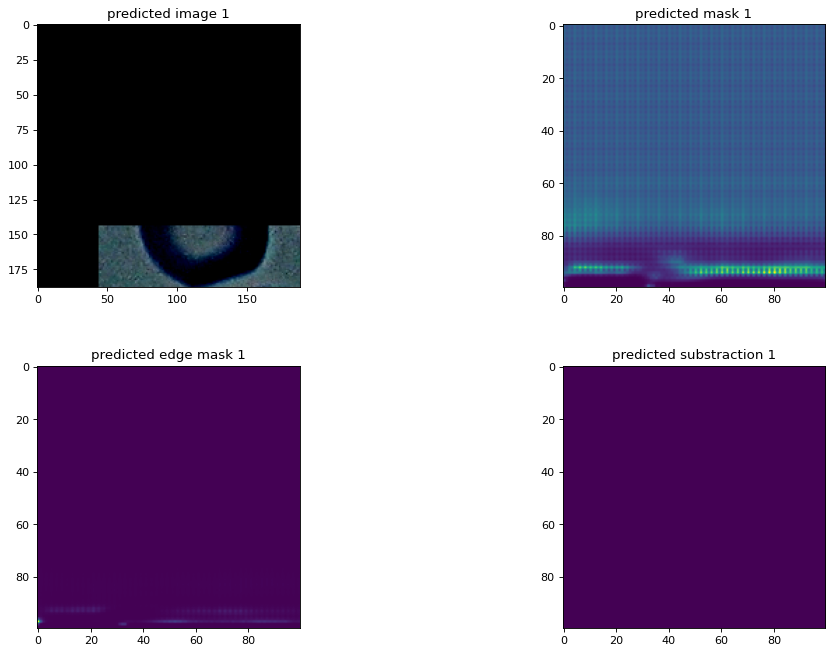

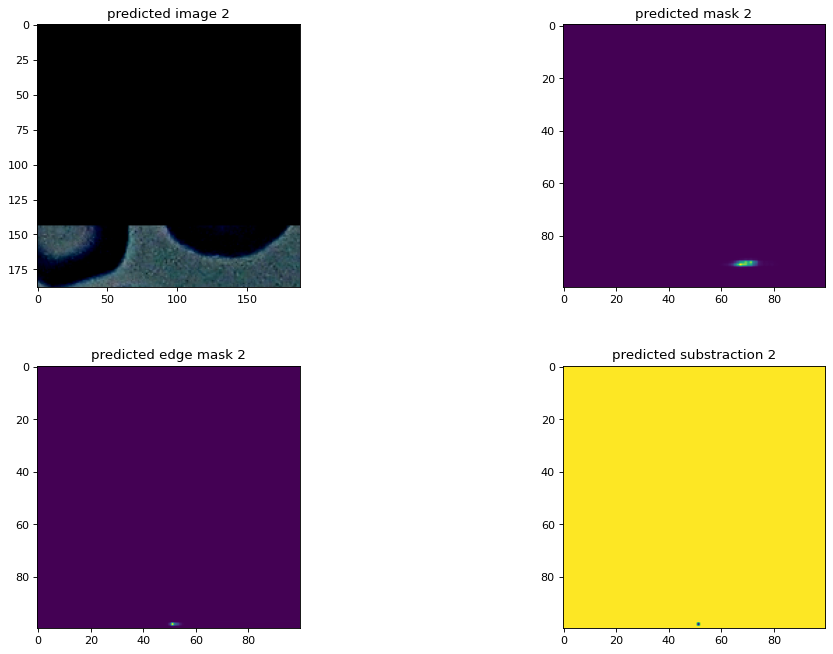

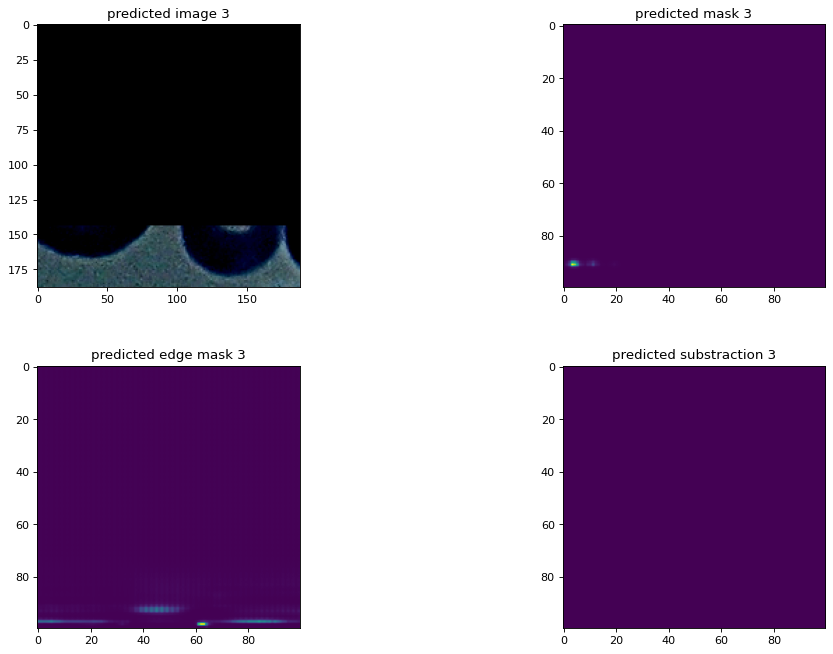

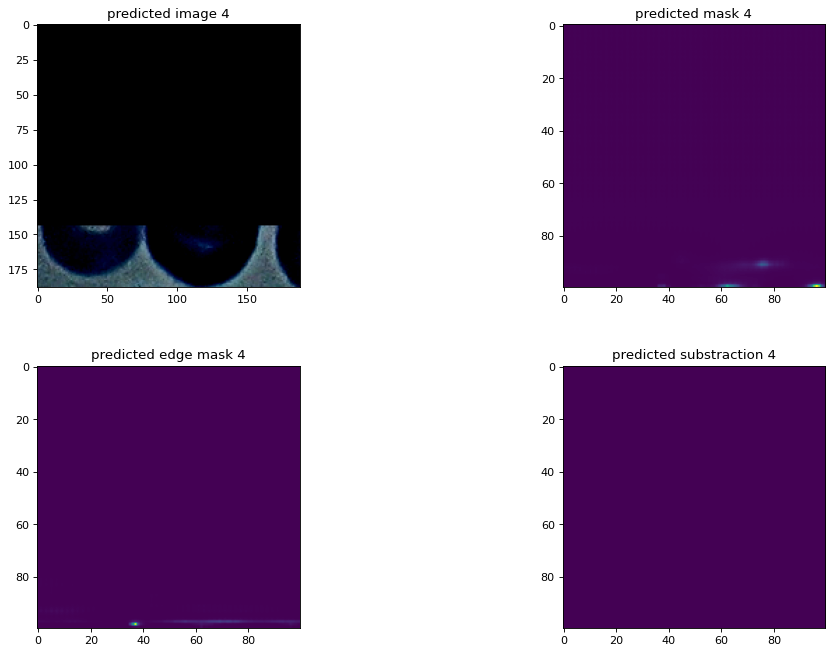

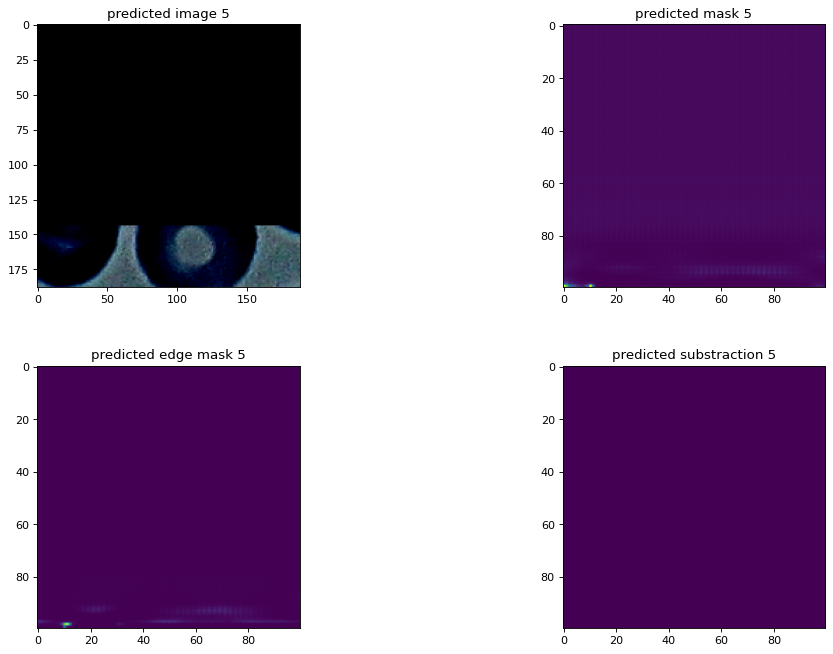

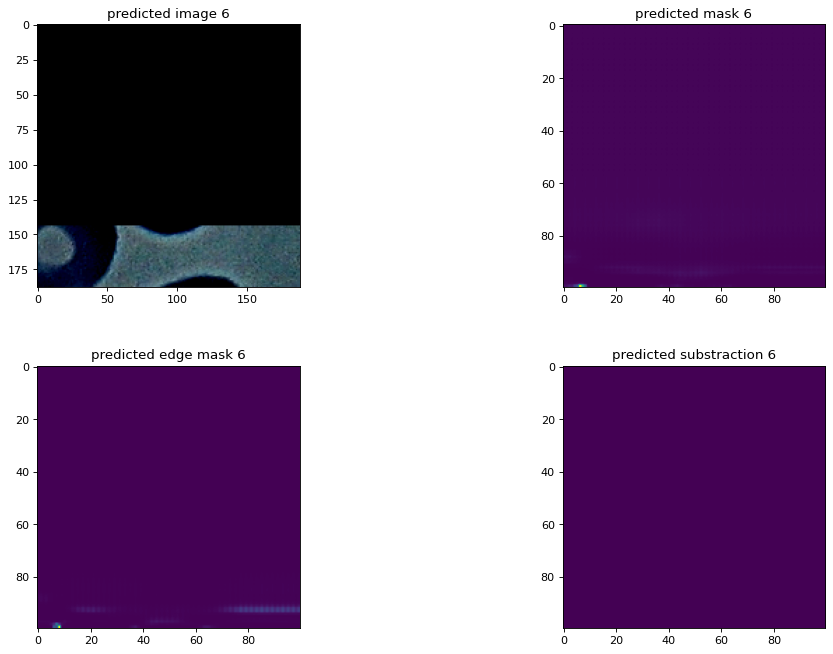

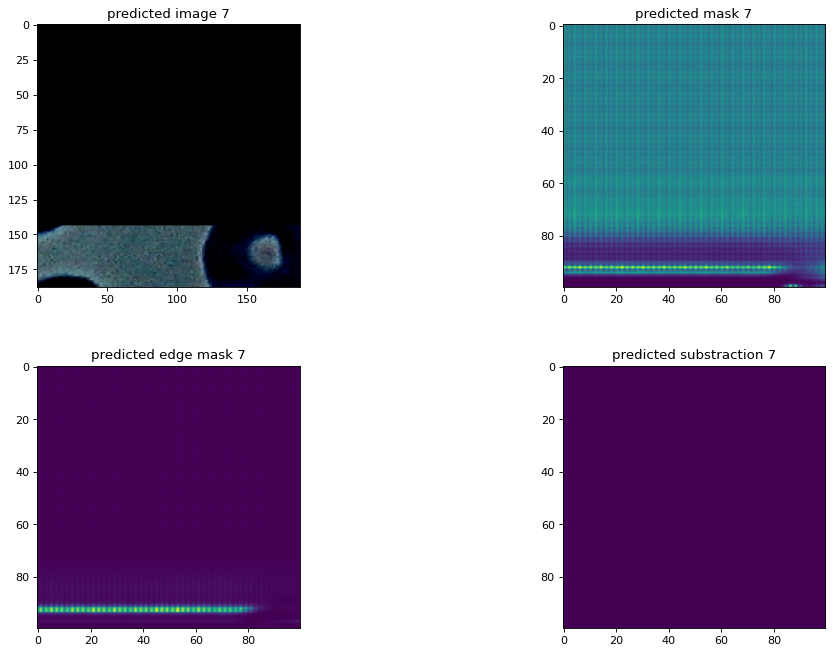

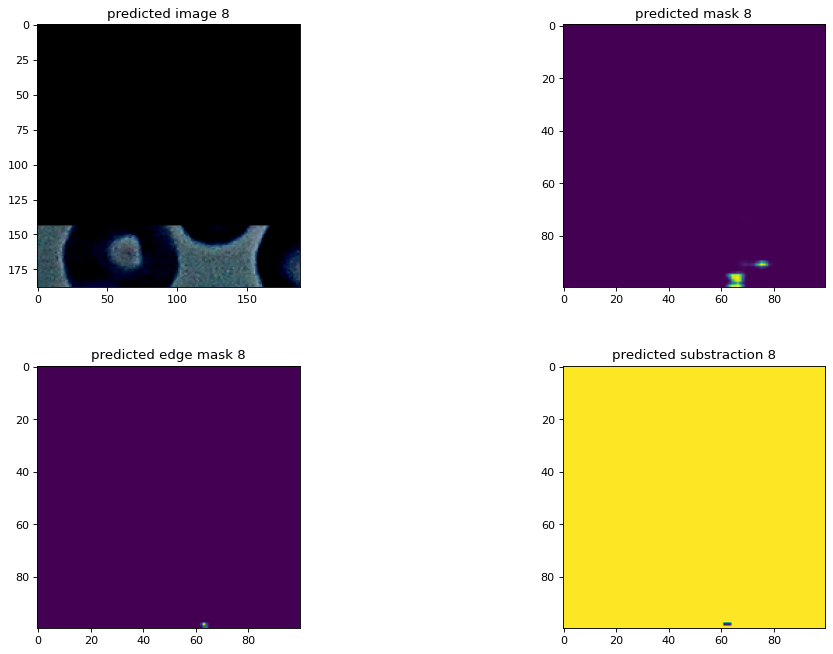

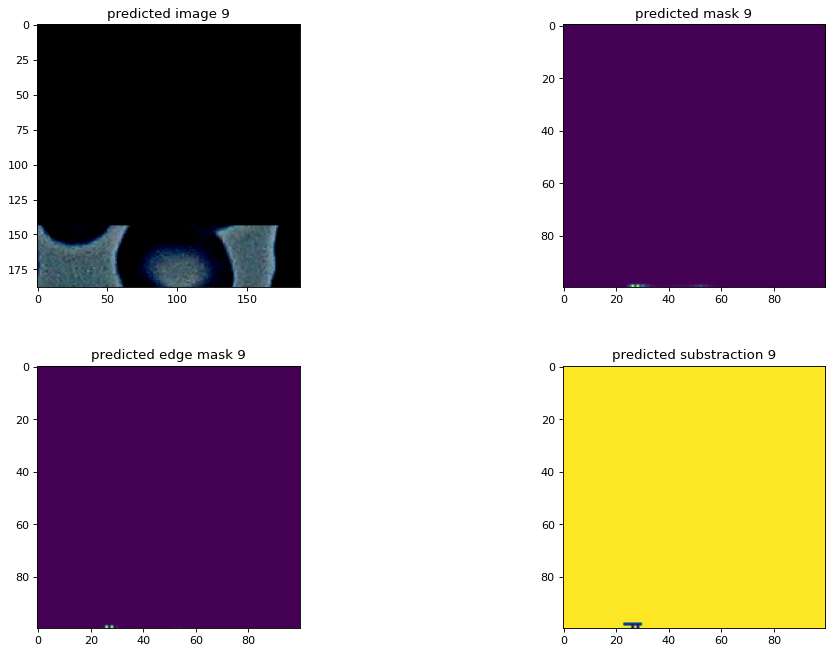

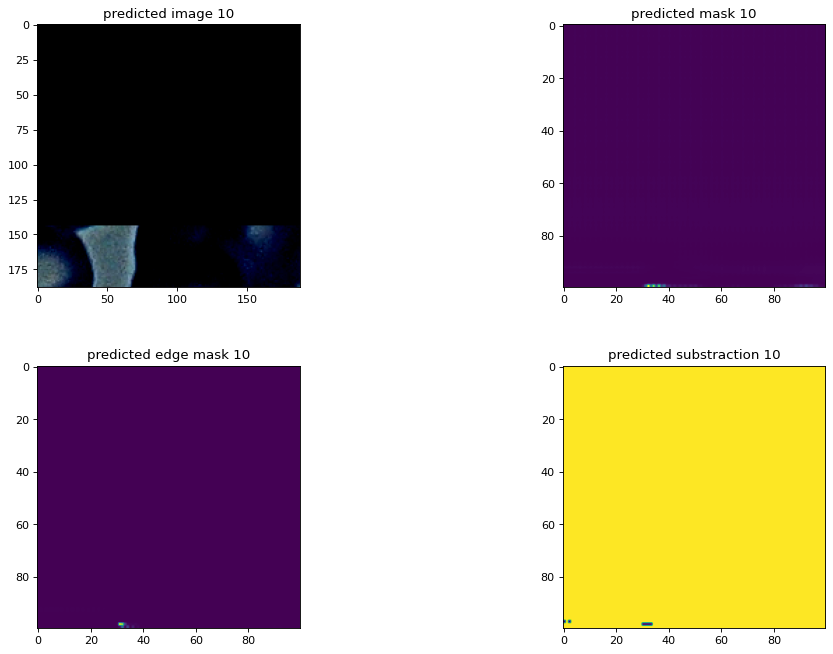

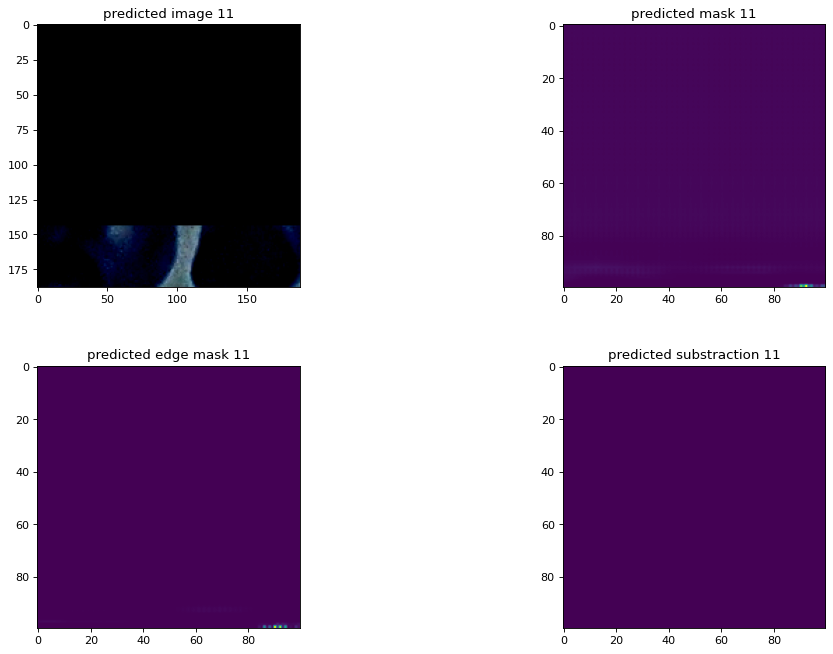

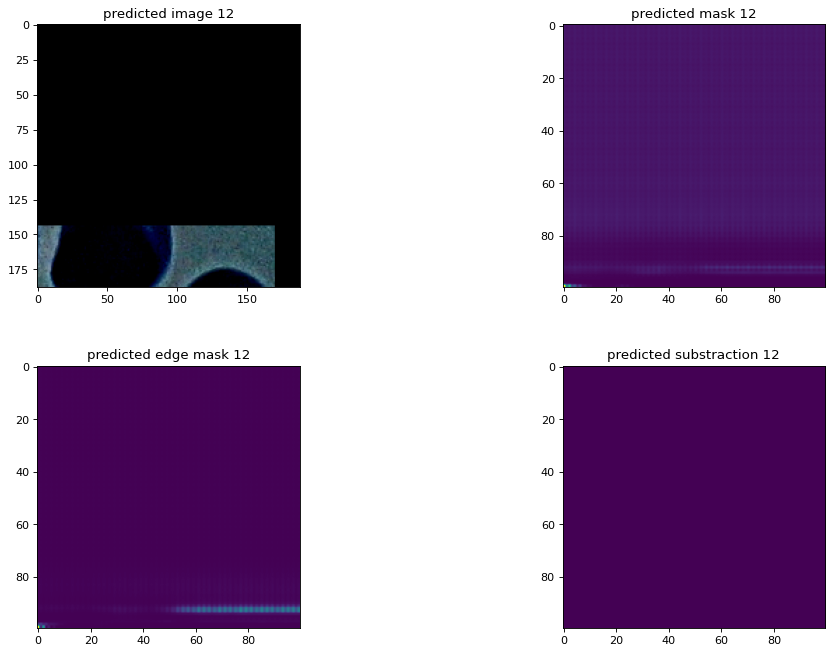

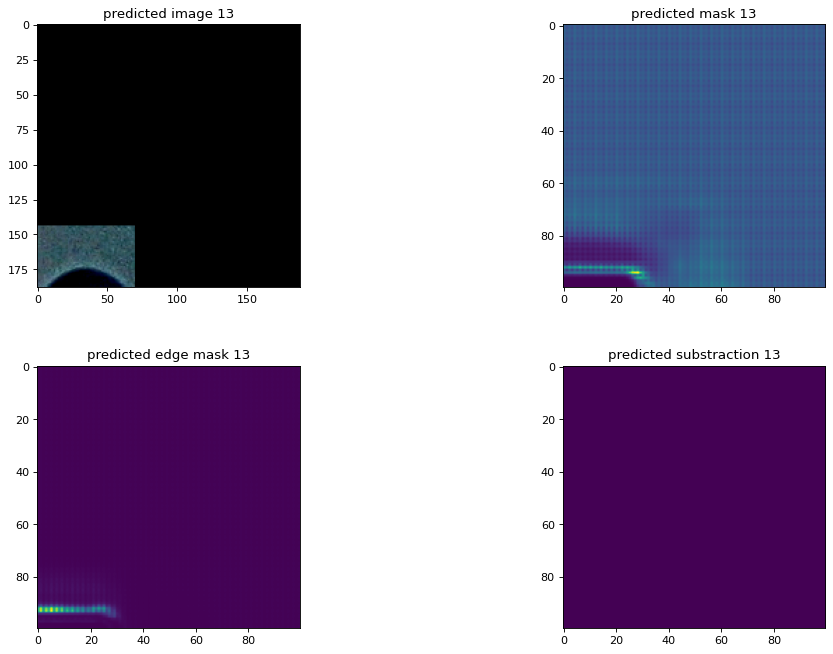

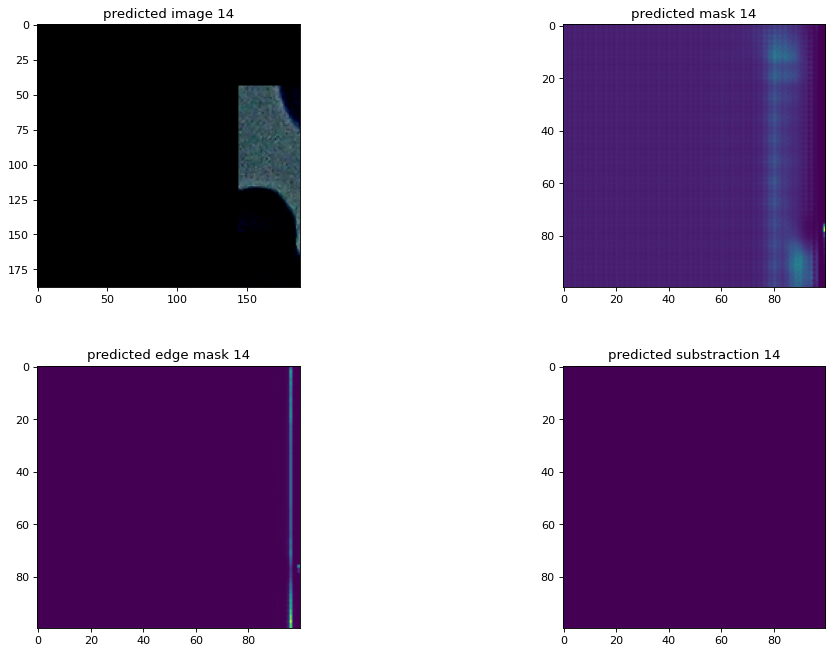

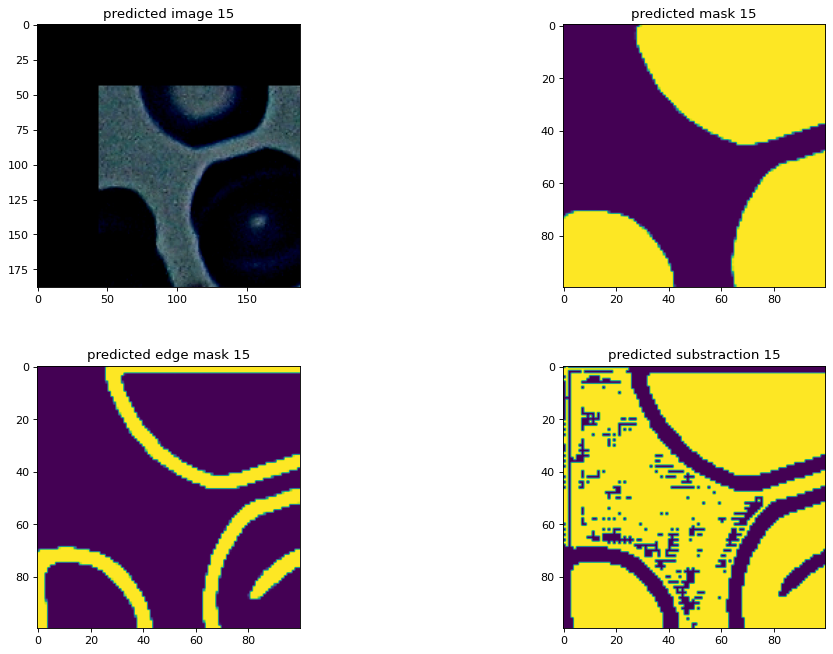

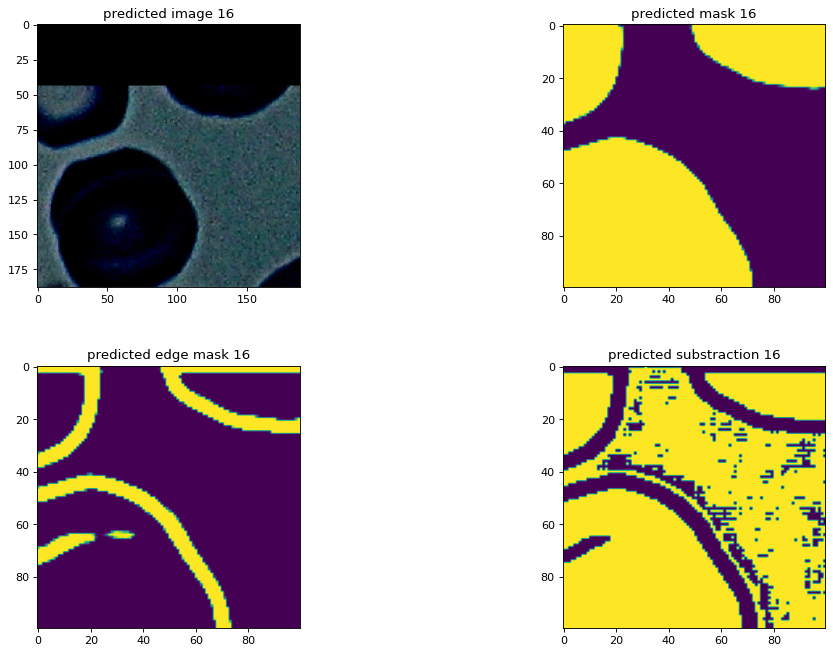

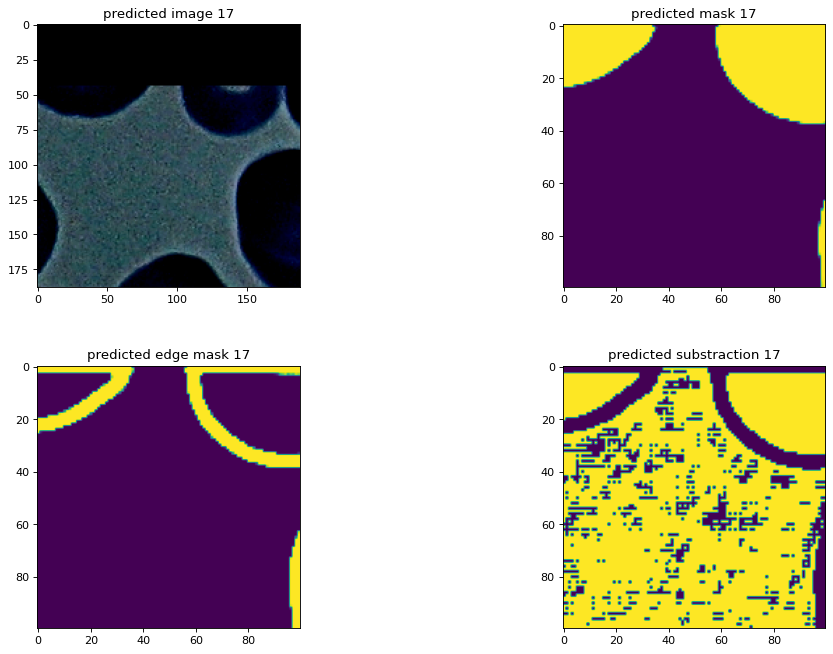

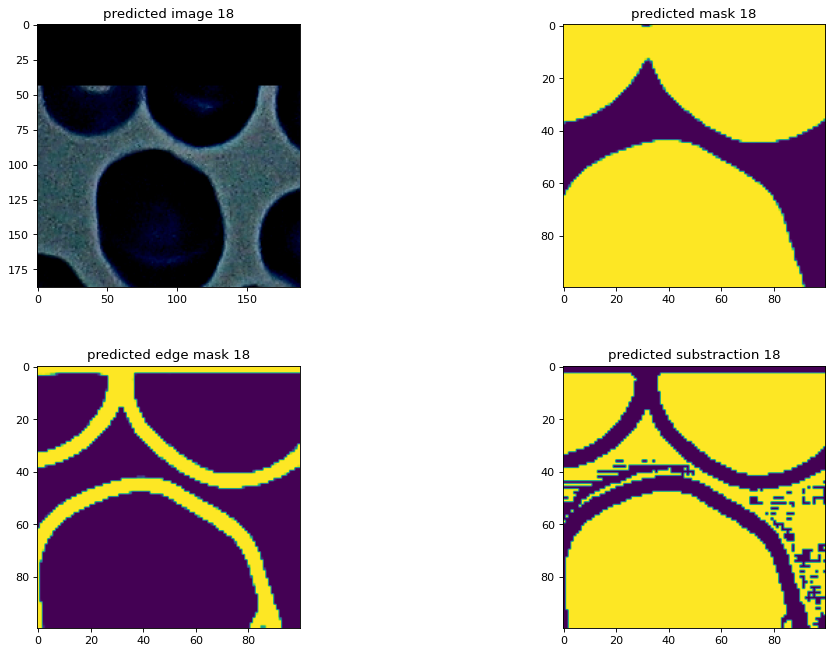

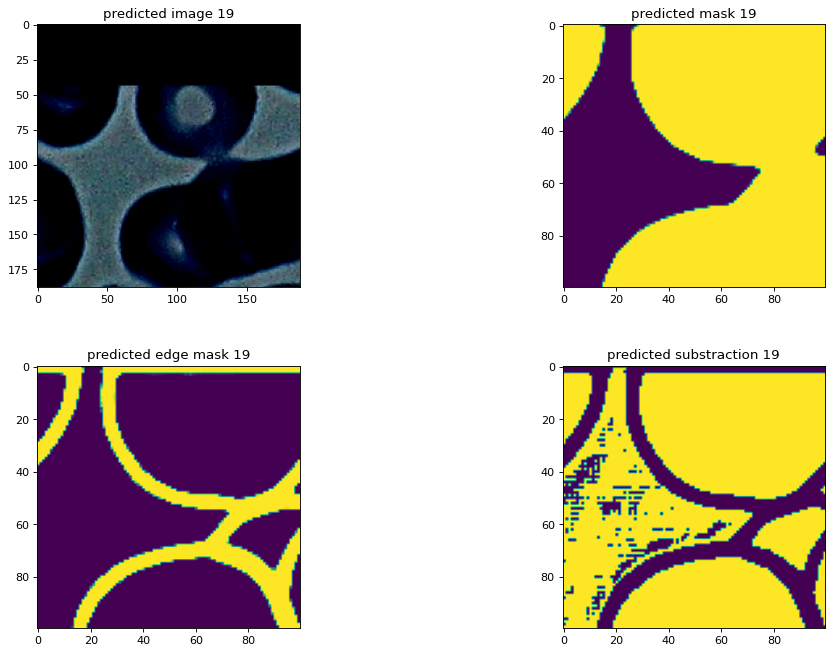

In [11]:
#rand_index = np.random.randint(0, len(test_img_chips), 1)[0]
#img = test_img_chips[rand_index]
#mask = np.squeeze(test_mask_chips[rand_index])
#edge = np.squeeze(test_edge_chips[rand_index])

test_img_chips, test_mask_chips, test_edge_chips = model.generate_test_dataset(test_img_files)


prediction = unet.predict(test_img_chips)

prediction = np.squeeze(prediction)

data.plot_ime(test_img_chips, prediction[0], prediction[1])



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


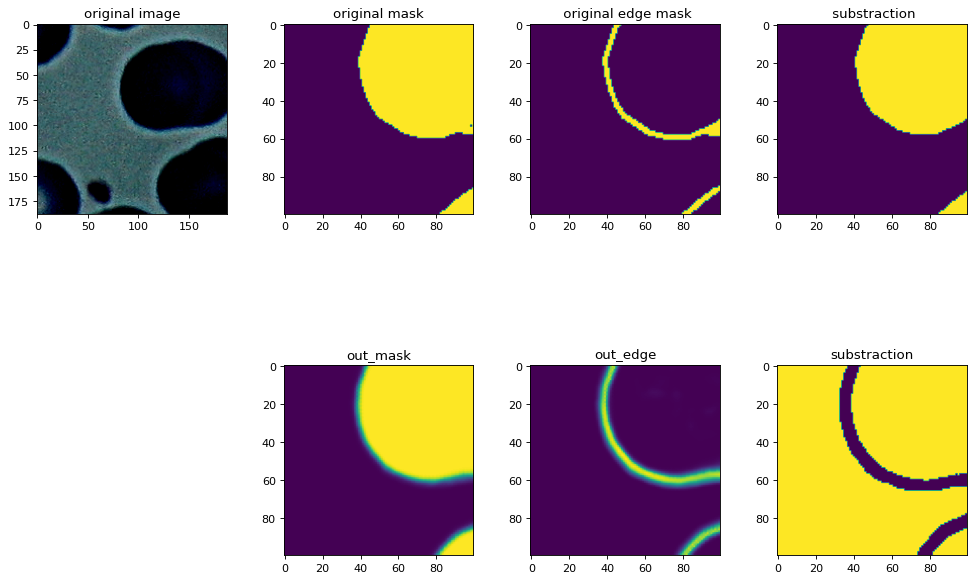

In [16]:
fig = plt.figure(figsize=(15, 10), dpi=80)
fig.subplots_adjust(hspace=0.3, wspace=0.3)
fig_num = 1
ax = fig.add_subplot(2, 4, fig_num)
ax.set_title("original image")
ax.imshow(img[0])
fig_num = fig_num + 1
ax = fig.add_subplot(2, 4, fig_num)
ax.set_title("original mask")
ax.imshow(mask)
fig_num = fig_num + 1
ax = fig.add_subplot(2, 4, fig_num)
ax.set_title(" original edge mask")
ax.imshow(edge)
fig_num = fig_num + 1
ax = fig.add_subplot(2, 4, fig_num)
ax.set_title(" substraction")
ax.imshow((mask - edge) > 0)


fig_num = fig_num + 2
ax = fig.add_subplot(2, 4, fig_num)
ax.set_title("out_mask")
ax.imshow(prediction[0])
fig_num = fig_num + 1
ax = fig.add_subplot(2, 4, fig_num)
ax.set_title("out_edge")
ax.imshow(prediction[1])
fig_num = fig_num + 1
ax = fig.add_subplot(2, 4, fig_num)
ax.set_title("substraction")
ax.imshow((prediction[0] - prediction[1]) > 0)




- predict full image

In [ ]:
images, masks, edges = model.predictFullImage(unet,
                          data.load_data_na(test_img_files, RGB=True, clahe=True),
                        padding=100,
                        input_size=188,
                        output_size=100,
                        normalize_output = False)

In [ ]:
data.plot_ime(images,
              masks,
              edges,
              figSize=(25,15))

## model training data plot

In [ ]:
hist = history.history

lines = 4
columns = 3

fig = plt.figure(figsize=(20, 20), dpi=80)
fig.subplots_adjust(hspace=0.3, wspace=0.3)
fig_num = 1
ax = fig.add_subplot(lines, columns, fig_num)
ax.set_title("mask accuracy")
ax.plot(hist['mask_acc'], label="Training")
ax.plot(hist['val_mask_acc'], label="Validation")
ax.legend()
fig_num = fig_num + 1
ax = fig.add_subplot(lines, columns, fig_num)
ax.set_title("edge mask accuracy")
ax.plot(hist['edge_acc'], label="Training")
ax.plot(hist['val_edge_acc'], label="Validation")
ax.legend()
fig_num = fig_num + 2
ax = fig.add_subplot(lines, columns, fig_num)
ax.set_title("mask loss")
ax.plot(hist['mask_loss'], label="Training")
ax.plot(hist['val_mask_loss'], label="Validation")
ax.legend()
fig_num = fig_num + 1
ax = fig.add_subplot(lines, columns, fig_num)
ax.set_title("edge loss")
ax.plot(hist['edge_loss'], label="Training")
ax.plot(hist['val_edge_loss'], label="Validation")
ax.legend()

fig_num = fig_num + 1
ax = fig.add_subplot(lines, columns, fig_num)
ax.set_title("global loss")
ax.plot(hist['loss'], label="Training")
ax.plot(hist['val_loss'], label="Validation")
ax.legend()


fig_num = fig_num + 1
ax = fig.add_subplot(lines, columns, fig_num)
ax.set_title("mask metrics")
ax.plot(hist['mask_dsc'], label="dsc")
ax.plot(hist['mask_mean_iou'], label="mean iou")
ax.plot(hist['mask_tversky'], label="tversky")
ax.plot(hist['mask_acc'], label="accuracy")

ax.set_title("mask metrics")
ax.plot(hist['val_mask_dsc'], label="val_dsc")
ax.plot(hist['val_mask_mean_iou'], label="val_mean iou")
ax.plot(hist['val_mask_tversky'], label="val_tversky")
ax.plot(hist['val_mask_acc'], label="val_accuracy")

fig_num = fig_num + 1
ax = fig.add_subplot(lines, columns, fig_num)
ax.set_title("edge metrics")
ax.plot(hist['edge_dsc'], label="dsc")
ax.plot(hist['edge_mean_iou'], label="mean iou")
ax.plot(hist['edge_tversky'], label="tversky")
ax.plot(hist['edge_acc'], label="accuracy")

ax.set_title("edge metrics")
ax.plot(hist['val_edge_dsc'], label="val_dsc")
ax.plot(hist['val_edge_mean_iou'], label="val_mean iou")
ax.plot(hist['val_edge_tversky'], label="val_tversky")
ax.plot(hist['val_edge_acc'], label="val_accuracy")
ax.legend()

## For Debugging
- show in between layers output

In [17]:
ind = np.random.randint(0, 32, 1)[0]

_pool1 = pool1[:-1,:-1,ind]
_pool2 = pool2[:-1,:-1,ind]
_pool3 = pool3[:-1,:-1,ind]
_down4 = down4[:-1,:-1,ind]
_up1 = up1[:-1,:-1,ind]
_up2 = up2[:-1,:-1,ind]
_up3 = up3[:-1,:-1,ind]

fig = plt.figure(figsize=(15, 10), dpi=80)
fig.subplots_adjust(hspace=0.3, wspace=0.3)
fig_num = 1
ax = fig.add_subplot(3, 3, fig_num)
ax.set_title("out_mask")
ax.imshow(out_mask)
fig_num = fig_num + 1
ax = fig.add_subplot(3, 3, fig_num)
ax.set_title("out_edge")
ax.imshow(out_edge)
fig_num = fig_num + 1
ax = fig.add_subplot(3, 3, fig_num)
ax.set_title("pool1")
ax.imshow(_pool1)
fig_num = fig_num + 1
ax = fig.add_subplot(3, 3, fig_num)
ax.set_title("pool2")
ax.imshow(_pool2)
fig_num = fig_num + 1
ax = fig.add_subplot(3, 3, fig_num)
ax.set_title("pool3")
ax.imshow(_pool3)
fig_num = fig_num + 1
ax = fig.add_subplot(3, 3, fig_num)
ax.set_title("down4")
ax.imshow(_down4)
fig_num = fig_num + 1
ax = fig.add_subplot(3, 3, fig_num)
ax.set_title("up1")
ax.imshow(_up1)
fig_num = fig_num + 1
ax = fig.add_subplot(3, 3, fig_num)
ax.set_title("up2")
ax.imshow(_up2)
fig_num = fig_num + 1
ax = fig.add_subplot(3, 3, fig_num)
ax.set_title("up3")
ax.imshow(_up3)

NameError: name 'pool1' is not defined

- function to plot and array of images of shape (width, height, n_images)

In [ ]:
def picshow(img, title):
    num = img.shape[2]
    imgs_per_line = 4
    ax = num//imgs_per_line + 1
    ay = imgs_per_line
    fig =plt.figure(figsize=(30, num//imgs_per_line * 10))
    fig.subplots_adjust(hspace=0.1, wspace=0.1)
    for i in range(1,num + 1):
        sub = fig.add_subplot(ax,ay,i)
        sub.set_title(f"{title} {i}")
        sub.imshow(img[:-1,:-1,i - 1])
    plt.show()
    



In [ ]:
picshow(pool1, 'pool1 ')
picshow(pool2, 'pool2 ')
picshow(pool3, 'pool3 ')
picshow(down4, 'down4 ')
picshow(up1, 'up1 ')
picshow(up2, 'up2 ')
picshow(up3, 'up3 ')